# "Bare" Derivatives

The code vaguely gives sensical derivates without any additional fancy decorations in certain modes. Generally it works well with no CUDA kernels and no JIT-ing. Here is a basic demo...

Ben is pretty sure this is just doing the frozen assignment trick, but without a lot of the machinary to make it suitable for either CUDA kernels or JIT compilation. In practice one only gets derivatives of the position of halos, no other info will get passed through.

Overall this mode is not advised for real analysis use, but is a nice proof-of-concept test.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import fof.fofkd as fof

from jax.experimental.ode import odeint
import jax_cosmo as jc

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn,pm_forces
from jaxpm.kernels import *
from functools import partial
from jax import jit
from inspect import signature
from scipy import ndimage
import jax

from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
from jaxpm.kernels import PGD_kernel, fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.painting import cic_paint, cic_read

nc = 64
mesh_shape= [nc, nc, nc]
bs = 64
box_size  = [bs,bs,bs]
snapshots = jnp.linspace(0.1,1.0,10) #evolve to z=1


# Create a small function to generate the matter power spectrum
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=0.8), k)
pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))

initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(10))
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
cosmo = jc.Planck15(Omega_c=0.25, sigma8=0.8)
dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)

res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)


/home/ben.horowitz/miniconda3/envs/fof/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [11]:
from fof.utils import *
d=1.0
fof_output_fast = fof.fof_clusters_jit(res[0][-1],b=0.2*d*0.95,k=8,max_iters=200,cuda=False)

j_pos, j_masses = cluster_centers_masses_padded(res[0][-1],fof_output_fast[1])

mass_filt = j_masses>5

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


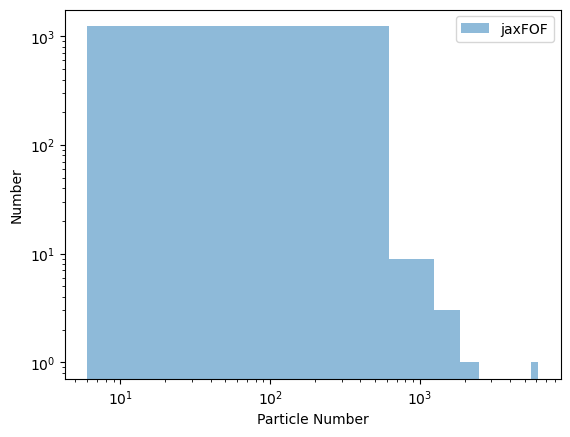

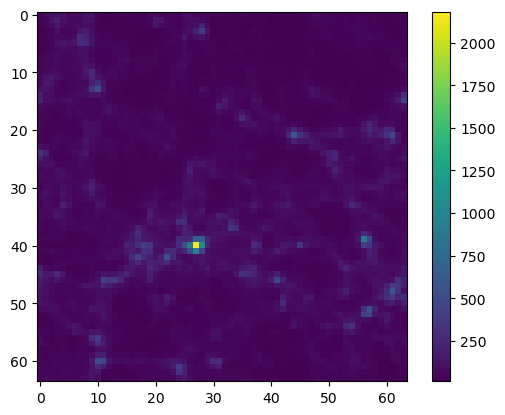

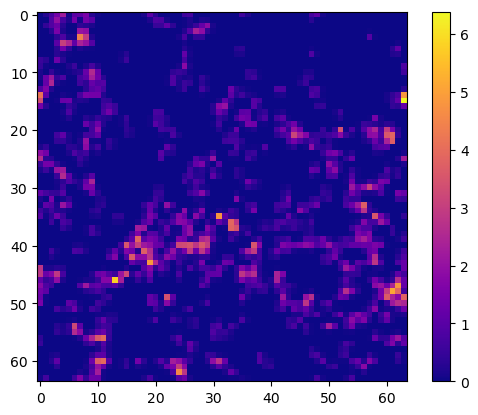

In [12]:
%pylab inline
_,bins, _ = plt.hist(j_masses[mass_filt],alpha=0.5,label="jaxFOF")
plt.loglog()
plt.legend()
plt.xlabel("Particle Number")
plt.ylabel("Number")
plt.show()
dens = cic_paint(jnp.zeros(mesh_shape),res[0][-1])
halos = cic_paint(jnp.zeros(mesh_shape),j_pos[mass_filt])

plt.imshow(dens.sum(axis=0))
plt.colorbar()
plt.show()


plt.imshow(halos.sum(axis=0),cmap="plasma")
plt.colorbar()
plt.show()

In [13]:
#derivative of a halo-field based likelihood with respect to cosmological parameters at fixed IC phases...


data = ndimage.gaussian_filter(halos,0.25)

def ex_pipeline(sigma8):
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=0.25, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape))
    
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(10))
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])
    cosmo = jc.Planck15(Omega_c=0.25, sigma8=sigma8)
    dx, p, f = lpt(cosmo, initial_conditions, particles, a=0.1)
    
    res = odeint(make_ode_fn(mesh_shape), [particles + dx, p], snapshots, cosmo, rtol=1e-8, atol=1e-8)

    #cuda=True no good in bare setup
    fof_output_fast = fof.fof_clusters_jit(res[0][-1],b=0.2*1*0.95,k=8,max_iters=200,cuda=False)
    
    #it would be nice to make masses more dynamic during backprop, maybe using movement of particles as a weighting term for mass?
    #i.e. if particles derivatives are net out interpret that as net mass reduction?
    j_pos, j_masses = cluster_centers_masses_padded(res[0][-1],fof_output_fast[1])

    #can probably make this jitable by cic_painting all halos and weight them by mass with some sigma_clipping
    mass_filt = j_masses>5

    halos = cic_paint(jnp.zeros(mesh_shape),j_pos[mass_filt])
    return jnp.sum((halos-data)**2)

print("gradient test...")
vag = jax.value_and_grad(ex_pipeline)
print(vag(0.6))
print(vag(0.7))
print(vag(0.8))
print(vag(0.9))
print(vag(1.0))


gradient test...


/home/ben.horowitz/miniconda3/envs/fof/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array(1114.3345, dtype=float32), Array(-1694.6061, dtype=float32))
(Array(810.61084, dtype=float32), Array(-4505.1304, dtype=float32))
(Array(1.1159801, dtype=float32), Array(-11.445987, dtype=float32))
(Array(786.69226, dtype=float32), Array(4732.4443, dtype=float32))
(Array(1182.884, dtype=float32), Array(2561.829, dtype=float32))


In [14]:
#you can see the sign of gradient is pointing the right direction!! :/-< :|-< :\-< (that is a dancing person!)